In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

## Function Making 

In [2]:
def clean_LLMgrades(grade_dataframe):
    
    """Cleans the dataframe, changing index labels and removing unnecessary rows"""
    
    #removes excess rows
    cleaned_dataframe = grade_dataframe.head(11)
    
    #removes and uses first row as dataframe index
    cleaned_dataframe.columns = cleaned_dataframe.iloc[0]
    cleaned_dataframe = cleaned_dataframe.drop(cleaned_dataframe.index[0])
    cleaned_dataframe = cleaned_dataframe.reset_index(drop=True)
    
    return cleaned_dataframe

def separate_grading_sheets(excelfile):
    
    """Takes the grading excel sheets and forms them into separate dataframes
       Each dataframe is then cleaned and indexed with the solutions."""
    
    #loads grading file
    grading = pd.ExcelFile(excelfile)
    
    #separates sheets
    EM_grading = pd.read_excel(grading, 'EM')
    QM_grading = pd.read_excel(grading, 'QM')
    CM_grading = pd.read_excel(grading, 'CM')
    
    #for loop
    grade_dataframes = [EM_grading, QM_grading, CM_grading]
    
    #cleans sheets
    EM_grading, QM_grading, CM_grading = [clean_LLMgrades(i) for i in grade_dataframes]
    
    return EM_grading, QM_grading, CM_grading

In [3]:
def mean_solution(gradingdatasheet):
    
    """takes each cleaned sheet, filters each solution with all trials and computes the 
       mean of each solution with standard error of mean. Converts them into percentages 
       out of total marks of each question"""
    
    #collect total marks
    totalmarks = gradingdatasheet.filter(like='Total Marks')
    
    #collects trials for each of solution 1, 2 and 3 by column (10x5)
    sol1 = gradingdatasheet.filter(like='Solution 1')
    sol2 = gradingdatasheet.filter(like='Solution 2')
    sol3 = gradingdatasheet.filter(like='Solution 3')
    
    #obtain mean values 
    sol1_avg = pd.DataFrame(np.mean(sol1, axis=1))
    sol2_avg = pd.DataFrame(np.mean(sol2, axis=1))
    sol3_avg = pd.DataFrame(np.mean(sol3, axis=1))
    
    #convert to percentage
    sol1_avg = np.array(sol1_avg.iloc[:, 0] / totalmarks.iloc[:, 0] *100)
    sol2_avg = np.array(sol2_avg.iloc[:, 0] / totalmarks.iloc[:, 0] *100)
    sol3_avg = np.array(sol3_avg.iloc[:, 0] / totalmarks.iloc[:, 0] *100)
    
    #obtain standard deviation (N-1) as percentage
    sol1_stdev = pd.DataFrame(np.std(sol1, axis=1, ddof=1))
    sol1_stdev = np.array(sol1_stdev.iloc[:, 0] / totalmarks.iloc[:, 0] *100)
    
    sol2_stdev = pd.DataFrame(np.std(sol2, axis=1, ddof=1))
    sol2_stdev = np.array(sol2_stdev.iloc[:, 0] / totalmarks.iloc[:, 0] *100)
    
    sol3_stdev = pd.DataFrame(np.std(sol3, axis=1, ddof=1))
    sol3_stdev = np.array(sol3_stdev.iloc[:, 0] / totalmarks.iloc[:, 0] *100)
    
    #obtain standard error of mean
    sol1_err = sol1_stdev / np.sqrt(np.shape(sol1)[1])
    sol2_err = sol2_stdev / np.sqrt(np.shape(sol2)[1])
    sol3_err = sol3_stdev / np.sqrt(np.shape(sol3)[1])
    
    return sol1_avg, sol2_avg, sol3_avg, sol1_err, sol2_err, sol3_err

In [4]:
def solution_data(excelfile):
    
    """For given LLM, markscheme or not, compile average and standard error percentage of all solutions """
    
    EM_grades, QM_grades, CM_grades = separate_grading_sheets(excelfile)

    #Get EM values, concatenate them
    EM_sol1, EM_sol2, EM_sol3, EM_sol1_err, EM_sol2_err, EM_sol3_err = mean_solution(EM_grades)
    EM_sol = np.concatenate((EM_sol1, EM_sol2, EM_sol3))
    EM_err = np.concatenate((EM_sol1_err, EM_sol2_err, EM_sol3_err))
    
    #Get QM values, concatenate them
    QM_sol1, QM_sol2, QM_sol3, QM_sol1_err, QM_sol2_err, QM_sol3_err = mean_solution(QM_grades)
    QM_sol = np.concatenate((QM_sol1, QM_sol2, QM_sol3))
    QM_err = np.concatenate((QM_sol1_err, QM_sol2_err, QM_sol3_err))
    
    #Get CM values, concatenate them
    CM_sol1, CM_sol2, CM_sol3, CM_sol1_err, CM_sol2_err, CM_sol3_err = mean_solution(CM_grades)
    CM_sol = np.concatenate((CM_sol1, CM_sol2, CM_sol3))
    CM_err = np.concatenate((CM_sol1_err, CM_sol2_err, CM_sol3_err))
    
    return EM_sol, QM_sol, CM_sol, EM_err, QM_err, CM_err

In [5]:
def LLMgradingplotting_noxerr(human_excelfile, nms_excelfile, ms_excelfile, nmstitle, mstitle, xaxis, yaxis, legendpos):
    
    """data required for plotting for each solution (as percentage)
       forms the best fit line parameters. Then plots """
    
    x_EM, x_QM, x_CM, x_EM_err, x_QM_err, x_CM_err = solution_data(human_excelfile)
    
    #compute data values (no markscheme and markscheme)
    nms_EM, nms_QM, nms_CM, nms_EM_err, nms_QM_err, nms_CM_err = solution_data(nms_excelfile)
    ms_EM, ms_QM, ms_CM, ms_EM_err, ms_QM_err, ms_CM_err = solution_data(ms_excelfile)
    
    #merge all EM, QM, CM data
    x_data = np.concatenate((x_EM, x_QM, x_CM)).astype(float)
    x_err = np.concatenate((x_EM_err, x_QM_err, x_CM_err)).astype(float)
    
    nms_data = np.concatenate((nms_EM, nms_QM, nms_CM)).astype(float)
    nms_err = np.concatenate((nms_EM_err, nms_QM_err, nms_CM_err)).astype(float)
    
    ms_data = np.concatenate((ms_EM, ms_QM, ms_CM)).astype(float)
    ms_err = np.concatenate((ms_EM_err, ms_QM_err, ms_CM_err)).astype(float)
    

    #unweighted curve fitting, correlation
    p_nms, nms_cov = np.polyfit(x_data, nms_data, 1, cov=True)
    p_nms_err = np.sqrt(np.diag(nms_cov))
    r_nms = np.corrcoef(x_data, nms_data)
    
    p_ms, ms_cov = np.polyfit(x_data, ms_data, 1, cov=True)
    p_ms_err = np.sqrt(np.diag(ms_cov))
    r_ms = np.corrcoef(x_data, ms_data)
    
    
    # Create a new figure with 2x2 subplots
    fig = plt.figure(figsize=(25, 12))
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1)
    plt.subplots_adjust(hspace=0.0)

    # Create and set the first subplot
    ax1 = fig.add_subplot(1, 2, 1)
    
    #plot of all datapoints (all grades)
    plt.title(nmstitle, fontsize=18)
    plt.plot(np.linspace(-5,110,100), np.linspace(-5,110,100), '--', label='Ideal Fit')
    plt.plot(np.linspace(-5,110,200),np.poly1d(p_nms)(np.linspace(-5,110,200)), label='Best fit', color='purple')

    plt.errorbar(x_EM, nms_EM, yerr = nms_EM_err,fmt='o',
             markersize=10,capsize=5, color='red', label='EM')
    plt.errorbar(x_QM, nms_QM, yerr = nms_QM_err,fmt='o',
             markersize=10,capsize=5, color='green', label='QM')
    plt.errorbar(x_CM, nms_CM, yerr = nms_CM_err,fmt='o',
             markersize=10,capsize=5, color='blue', label='CM')
    
    plt.xlabel(xaxis, fontsize=18)
    plt.ylabel(yaxis, fontsize=18)

    plt.xlim(-0.1,102)
    plt.ylim(-0.1,102)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc=legendpos, fontsize=22)

    ax2 = fig.add_subplot(1, 2, 2)

    #plot of all datapoints (all grades)
    plt.title(mstitle, fontsize=18)
    plt.plot(np.linspace(-5,110,100), np.linspace(-5,110,100), '--')
    plt.plot(np.linspace(-5,110,200),np.poly1d(p_ms)(np.linspace(-5,110,200)), label='Best fit', color='purple')
    
    plt.errorbar(x_EM, ms_EM, yerr = ms_EM_err,fmt='o',
             markersize=10,capsize=5, color='red', label='EM')
    plt.errorbar(x_QM, ms_QM, yerr = ms_QM_err,fmt='o',
             markersize=10,capsize=5, color='green', label='QM')
    plt.errorbar(x_CM, ms_CM, yerr = ms_CM_err,fmt='o',
             markersize=10,capsize=5, color='blue', label='CM')
    
    plt.xlabel(xaxis, fontsize=18)

    plt.xlim(-0.1,102)
    plt.ylim(-0.1,102)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    return p_nms, p_nms_err, r_nms, p_ms, p_ms, p_ms_err

def LLMgradingplotting_xerr(human_excelfile, nms_excelfile, ms_excelfile, nmstitle, mstitle, xaxis, yaxis, legendpos):
    
    """data required for plotting for each solution (as percentage)
       forms the best fit line parameters. Then plots """
    
    x_EM, x_QM, x_CM, x_EM_err, x_QM_err, x_CM_err = solution_data(human_excelfile)
    
    #compute data values (no markscheme and markscheme)
    nms_EM, nms_QM, nms_CM, nms_EM_err, nms_QM_err, nms_CM_err = solution_data(nms_excelfile)
    ms_EM, ms_QM, ms_CM, ms_EM_err, ms_QM_err, ms_CM_err = solution_data(ms_excelfile)
    
    #merge all EM, QM, CM data
    x_data = np.concatenate((x_EM, x_QM, x_CM)).astype(float)
    x_err = np.concatenate((x_EM_err, x_QM_err, x_CM_err)).astype(float)
    
    nms_data = np.concatenate((nms_EM, nms_QM, nms_CM)).astype(float)
    nms_err = np.concatenate((nms_EM_err, nms_QM_err, nms_CM_err)).astype(float)
    
    ms_data = np.concatenate((ms_EM, ms_QM, ms_CM)).astype(float)
    ms_err = np.concatenate((ms_EM_err, ms_QM_err, ms_CM_err)).astype(float)
    

    #unweighted curve fitting, correlation
    p_nms, nms_cov = np.polyfit(x_data, nms_data, 1, cov=True)
    p_nms_err = np.sqrt(np.diag(nms_cov))
    r_nms = np.corrcoef(x_data, nms_data)
    
    p_ms, ms_cov = np.polyfit(x_data, ms_data, 1, cov=True)
    p_ms_err = np.sqrt(np.diag(ms_cov))
    r_ms = np.corrcoef(x_data, ms_data)
    
    
    # Create a new figure with 2x2 subplots
    fig = plt.figure(figsize=(25, 12))
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1)
    plt.subplots_adjust(hspace=0.0)

    # Create and set the first subplot
    ax1 = fig.add_subplot(1, 2, 1)
    
    #plot of all datapoints (all grades)
    plt.title(nmstitle, fontsize=18)
    plt.plot(np.linspace(-5,110,100), np.linspace(-5,110,100), '--', label='Ideal Fit')
    plt.plot(np.linspace(-5,110,200),np.poly1d(p_nms)(np.linspace(-5,110,200)), label='Best fit', color='purple')

    plt.errorbar(x_EM, nms_EM, xerr = x_EM_err, yerr = nms_EM_err,fmt='o',
             markersize=10,capsize=5, color='red', label='EM')
    plt.errorbar(x_QM, nms_QM, xerr = x_QM_err, yerr = nms_QM_err,fmt='o',
             markersize=10,capsize=5, color='green', label='QM')
    plt.errorbar(x_CM, nms_CM, xerr = x_CM_err, yerr = nms_CM_err,fmt='o',
             markersize=10,capsize=5, color='blue', label='CM')
    
    plt.xlabel(xaxis, fontsize=18)
    plt.ylabel(yaxis, fontsize=18)

    plt.xlim(-0.1,102)
    plt.ylim(-0.1,102)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc=legendpos, fontsize=22)

    ax2 = fig.add_subplot(1, 2, 2)

    #plot of all datapoints (all grades)
    plt.title(mstitle, fontsize=18)
    plt.plot(np.linspace(-5,110,100), np.linspace(-5,110,100), '--')
    plt.plot(np.linspace(-5,110,200),np.poly1d(p_ms)(np.linspace(-5,110,200)), label='Best fit', color='purple')
    
    plt.errorbar(x_EM, ms_EM, xerr = x_EM_err, yerr = ms_EM_err,fmt='o',
             markersize=10,capsize=5, color='red', label='EM')
    plt.errorbar(x_QM, ms_QM, xerr = x_QM_err, yerr = ms_QM_err,fmt='o',
             markersize=10,capsize=5, color='green', label='QM')
    plt.errorbar(x_CM, ms_CM, xerr = x_CM_err, yerr = ms_CM_err,fmt='o',
             markersize=10,capsize=5, color='blue', label='CM')
    
    plt.xlabel(xaxis, fontsize=18)

    plt.xlim(-0.1,102)
    plt.ylim(-0.1,102)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    return

## GPT-4 Grading

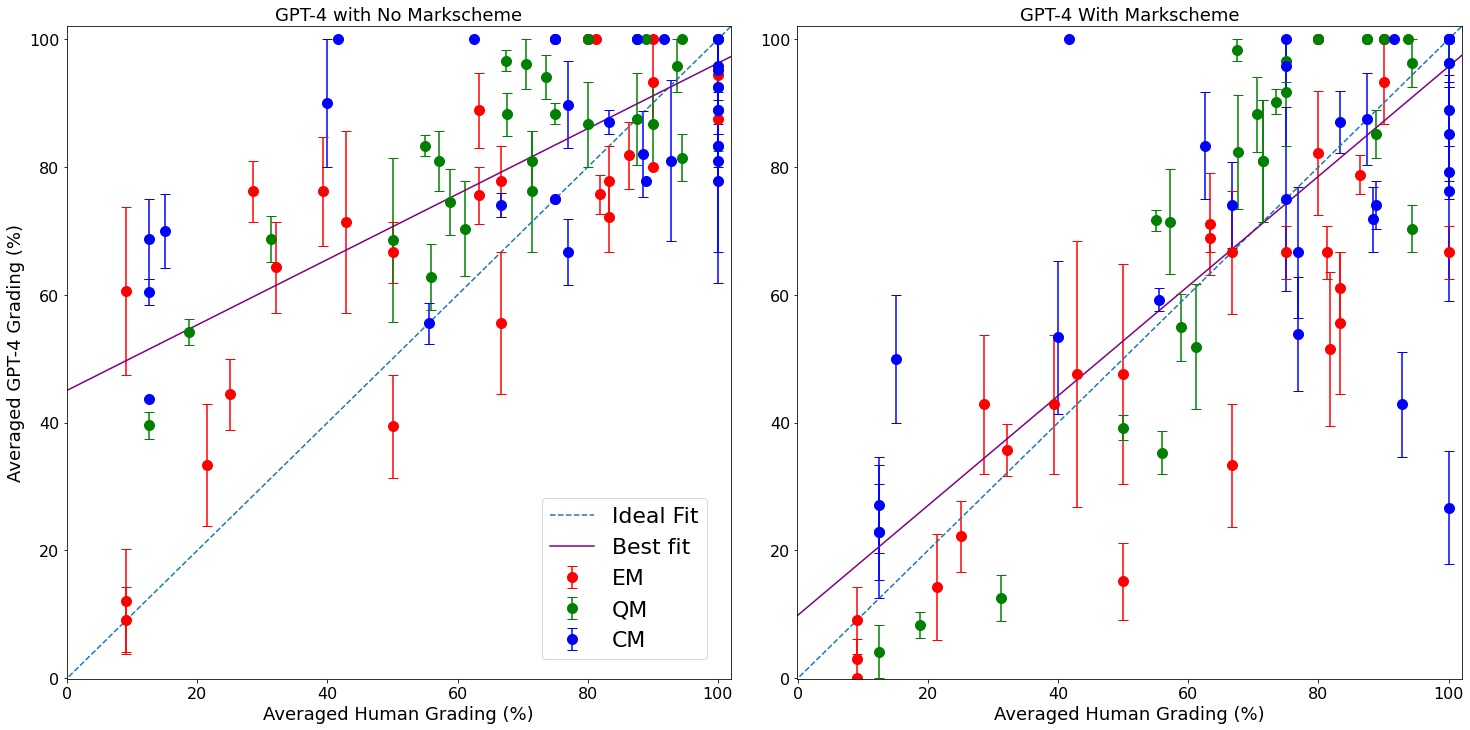

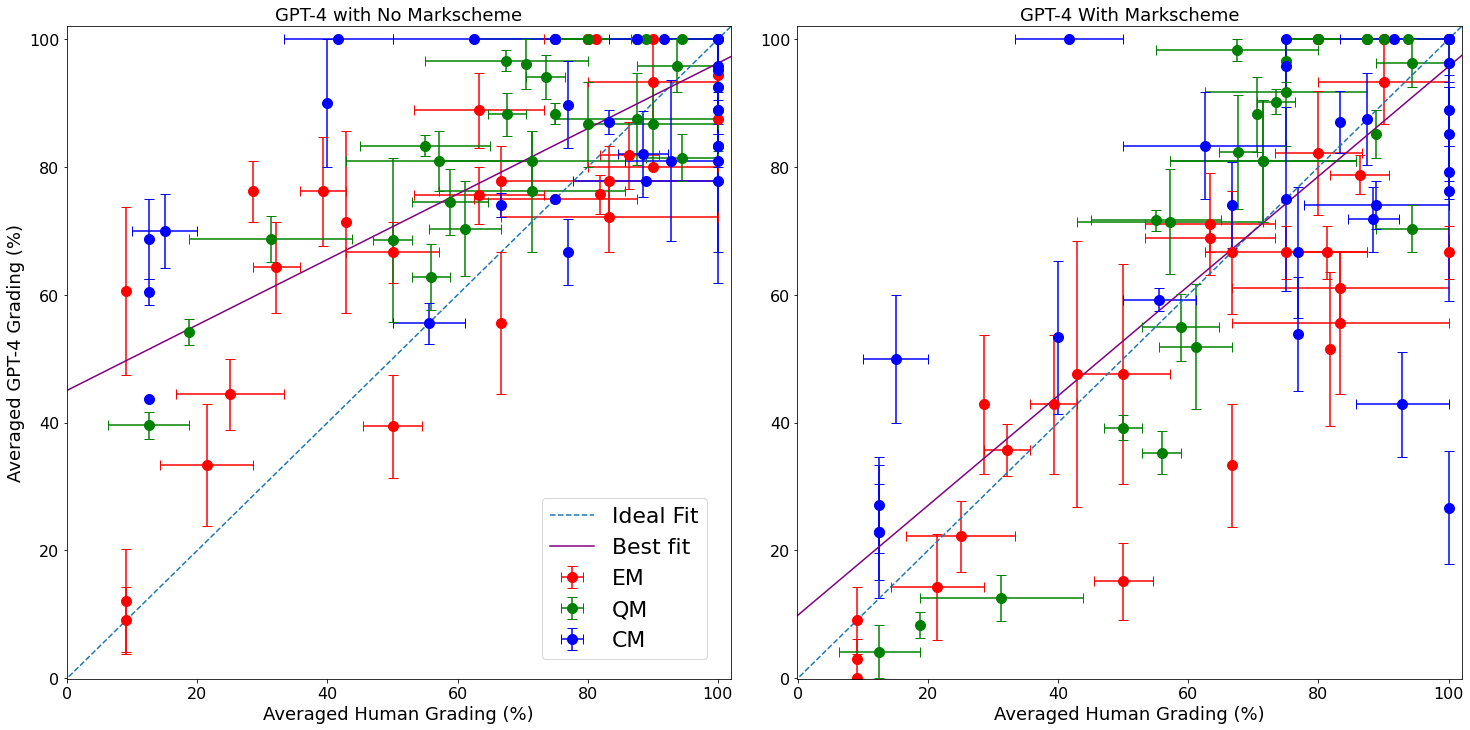

In [6]:
p_gpt4_nms, p_gpt4_nms_err, r_gpt4_nms, p_gpt4_ms, p_gpt4_ms_err, r_gpt4_ms = LLMgradingplotting_noxerr(
                                                                  'Human Graded.xlsx', 
                                                                  'GPT-4.xlsx', 
                                                                  'GPT-4MS.xlsx', 
                                                                  'GPT-4 with No Markscheme', 
                                                                  'GPT-4 With Markscheme', 
                                                                  'Averaged Human Grading (%)', 
                                                                  'Averaged GPT-4 Grading (%)', 
                                                                  [0.715,0.03])

LLMgradingplotting_xerr(
                                                                  'Human Graded.xlsx', 
                                                                  'GPT-4.xlsx', 
                                                                  'GPT-4MS.xlsx', 
                                                                  'GPT-4 with No Markscheme', 
                                                                  'GPT-4 With Markscheme', 
                                                                  'Averaged Human Grading (%)', 
                                                                  'Averaged GPT-4 Grading (%)', 
                                                                  [0.715,0.03])

## GPT-4o 

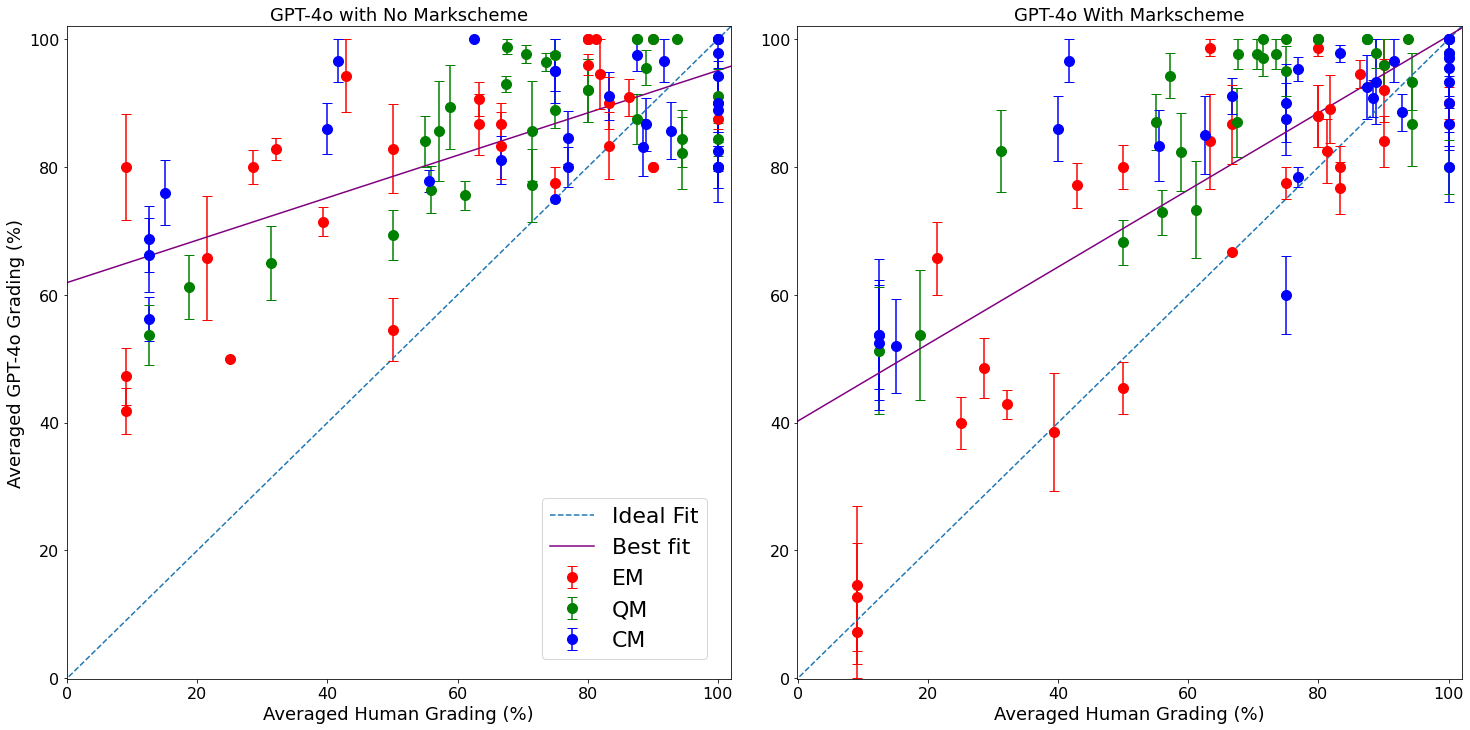

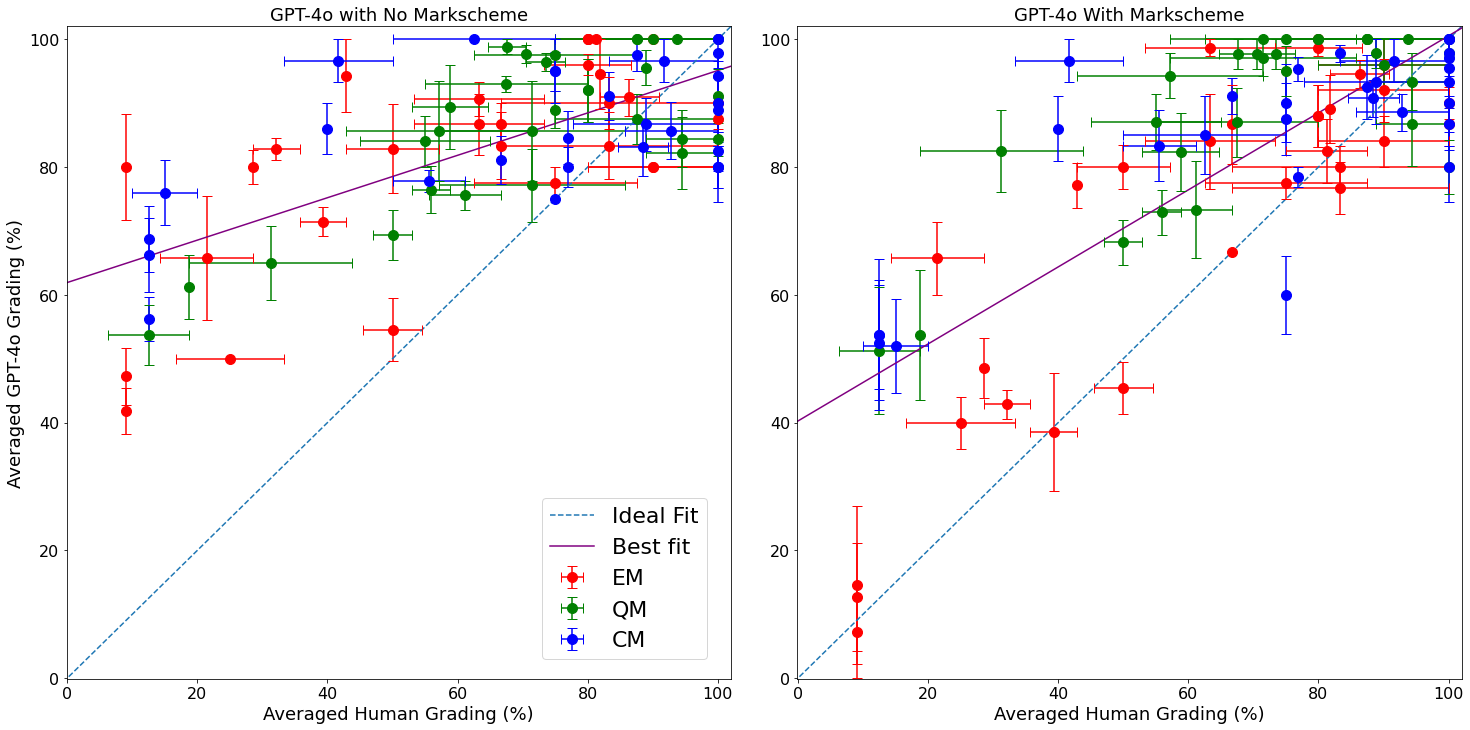

In [7]:
p_gpt4o_nms, p_gpt4o_nms_err, r_gpt4o_nms, p_gpt4o_ms, p_gpt4o_ms_err, r_gpt4o_ms = LLMgradingplotting_noxerr(
                                                                  'Human Graded.xlsx', 
                                                                  'GPT-4o.xlsx', 
                                                                  'GPT-4oMS.xlsx', 
                                                                  'GPT-4o with No Markscheme', 
                                                                  'GPT-4o With Markscheme', 
                                                                  'Averaged Human Grading (%)', 
                                                                  'Averaged GPT-4o Grading (%)', 
                                                                  [0.715,0.03])

LLMgradingplotting_xerr(
                                                                  'Human Graded.xlsx', 
                                                                  'GPT-4o.xlsx', 
                                                                  'GPT-4oMS.xlsx', 
                                                                  'GPT-4o with No Markscheme', 
                                                                  'GPT-4o With Markscheme', 
                                                                  'Averaged Human Grading (%)', 
                                                                  'Averaged GPT-4o Grading (%)', 
                                                                  [0.715,0.03])

## Claude 3.5 Sonnet

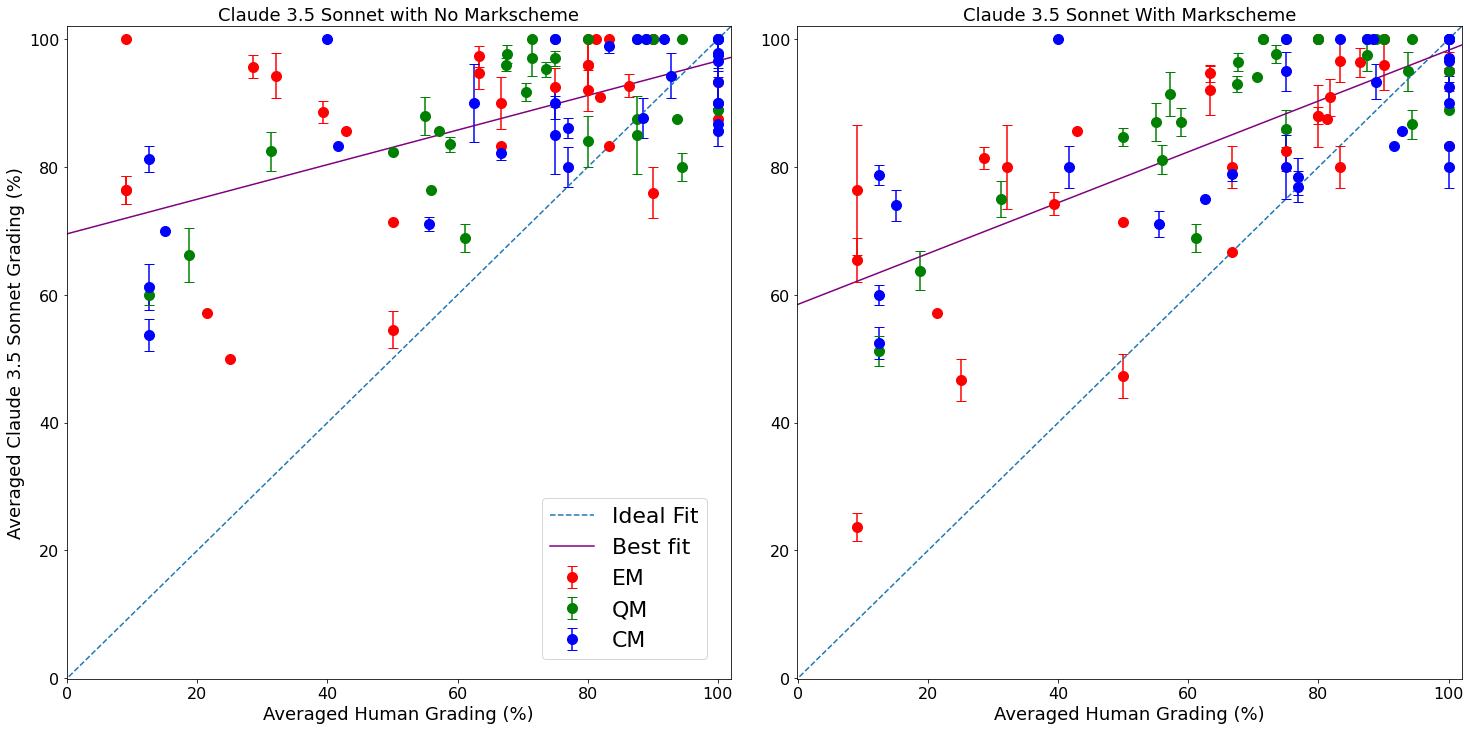

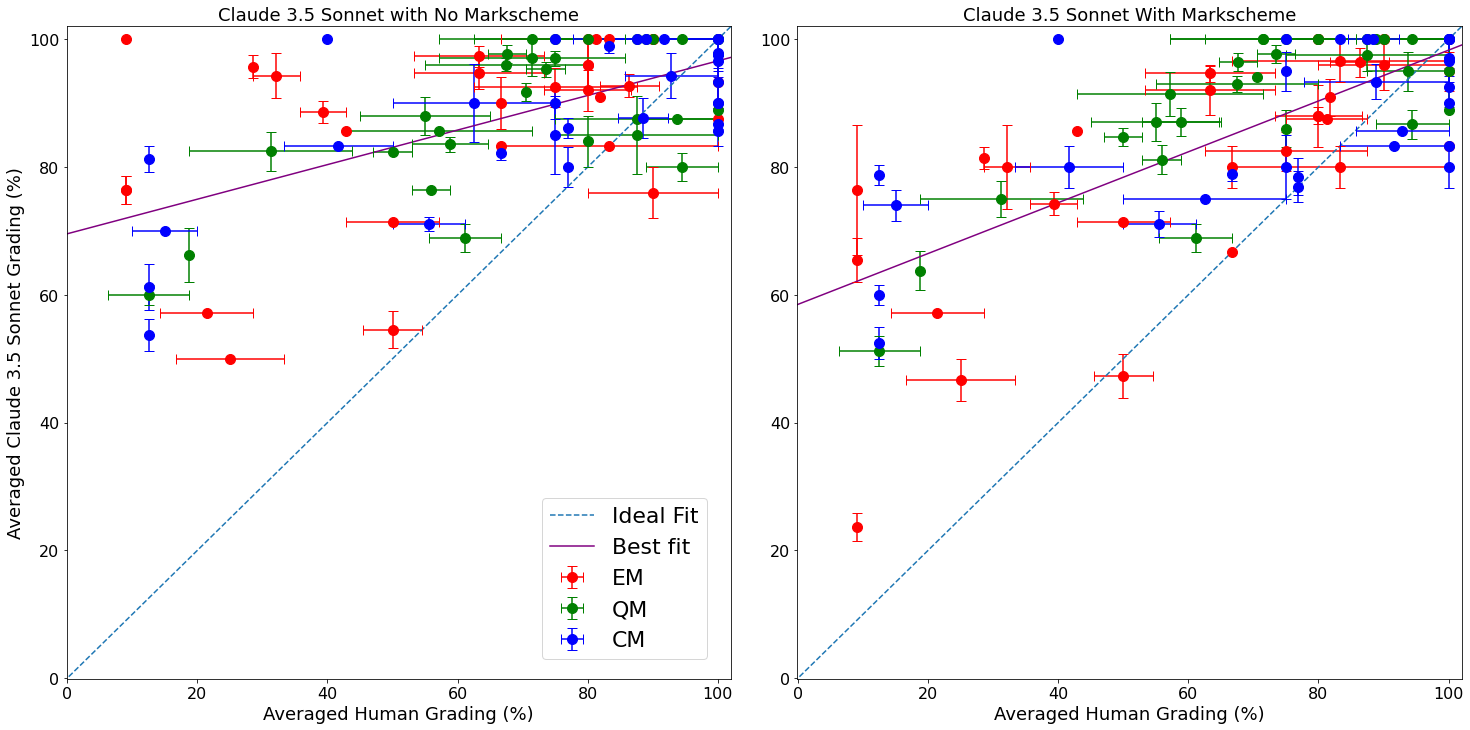

In [8]:
p_claude_nms, p_claude_nms_err, r_claude_nms, p_claude_ms, p_claude_ms_err, r_claude_ms = LLMgradingplotting_noxerr(
                                                                                      'Human Graded.xlsx', 
                                                                                      'Claude3.5Sonnet.xlsx', 
                                                                                      'Claude3.5SonnetMS.xlsx', 
                                                                                      'Claude 3.5 Sonnet with No Markscheme', 
                                                                                      'Claude 3.5 Sonnet With Markscheme', 
                                                                                      'Averaged Human Grading (%)', 
                                                                                      'Averaged Claude 3.5 Sonnet Grading (%)', 
                                                                                      [0.715,0.03])

LLMgradingplotting_xerr(
                                                                                      'Human Graded.xlsx', 
                                                                                      'Claude3.5Sonnet.xlsx', 
                                                                                      'Claude3.5SonnetMS.xlsx', 
                                                                                      'Claude 3.5 Sonnet with No Markscheme', 
                                                                                      'Claude 3.5 Sonnet With Markscheme', 
                                                                                      'Averaged Human Grading (%)', 
                                                                                      'Averaged Claude 3.5 Sonnet Grading (%)', 
                                                                                      [0.715,0.03])

## Gemini 1.5 Pro

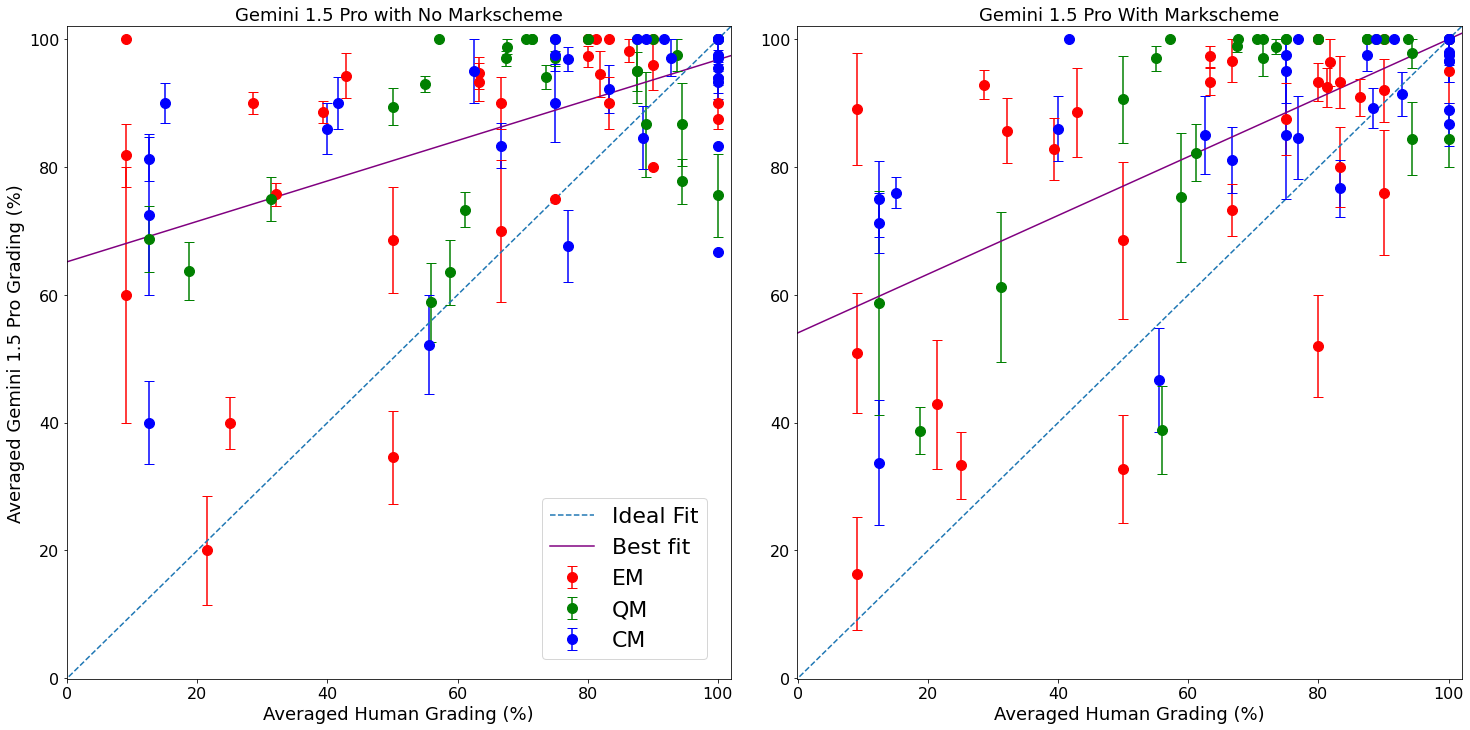

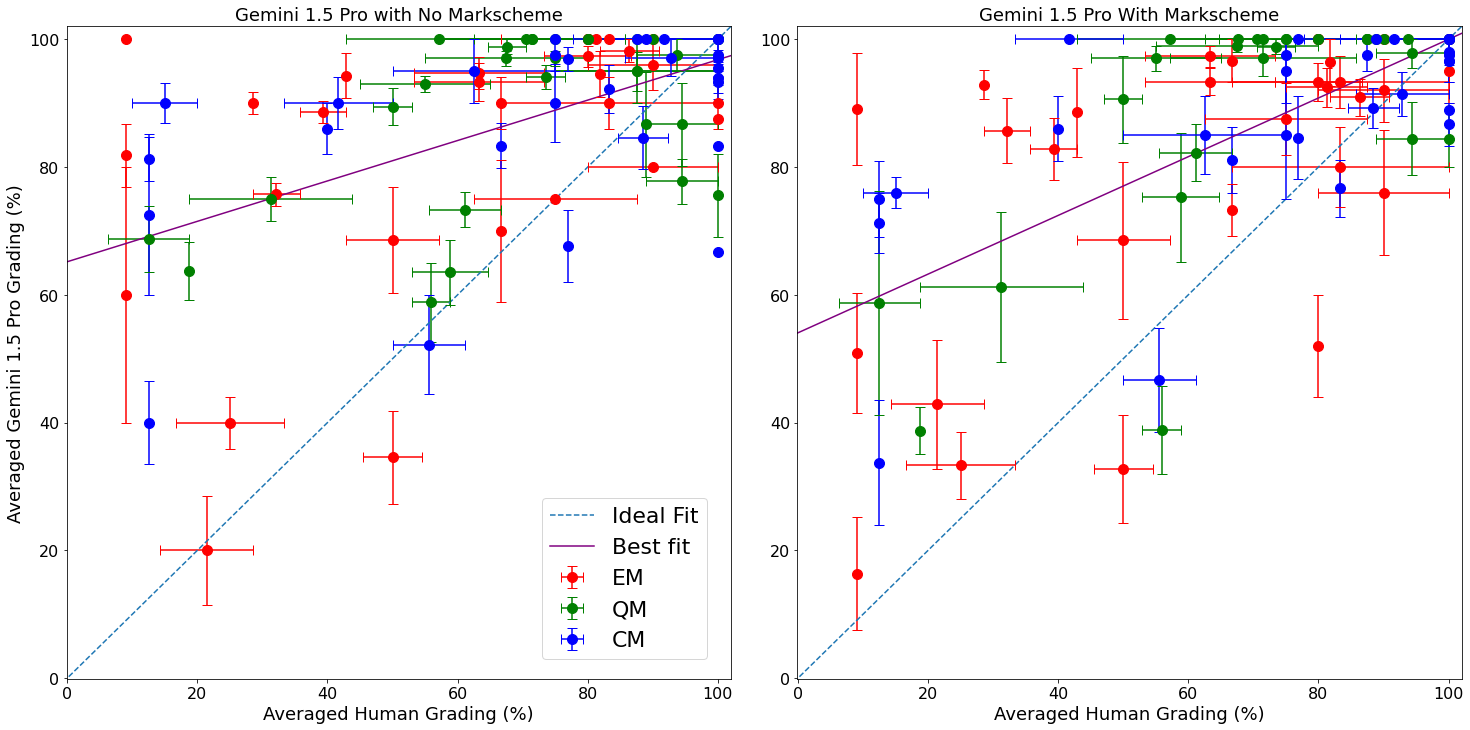

In [9]:
p_gem_nms, p_gem_nms_err, r_gem_nms, p_gem_ms, p_gem_ms_err, r_gem_ms = LLMgradingplotting_noxerr('Human Graded.xlsx', 
                                                                          'Gemini1.5Pro.xlsx', 
                                                                          'Gemini1.5ProMS.xlsx', 
                                                                          'Gemini 1.5 Pro with No Markscheme', 
                                                                          'Gemini 1.5 Pro With Markscheme',
                                                                          'Averaged Human Grading (%)',
                                                                          'Averaged Gemini 1.5 Pro Grading (%)',
                                                                          [0.715,0.03])

LLMgradingplotting_xerr(
                                                                          'Human Graded.xlsx', 
                                                                          'Gemini1.5Pro.xlsx', 
                                                                          'Gemini1.5ProMS.xlsx', 
                                                                          'Gemini 1.5 Pro with No Markscheme', 
                                                                          'Gemini 1.5 Pro With Markscheme',
                                                                          'Averaged Human Grading (%)',
                                                                          'Averaged Gemini 1.5 Pro Grading (%)',
                                                                          [0.715,0.03])

## Comparison

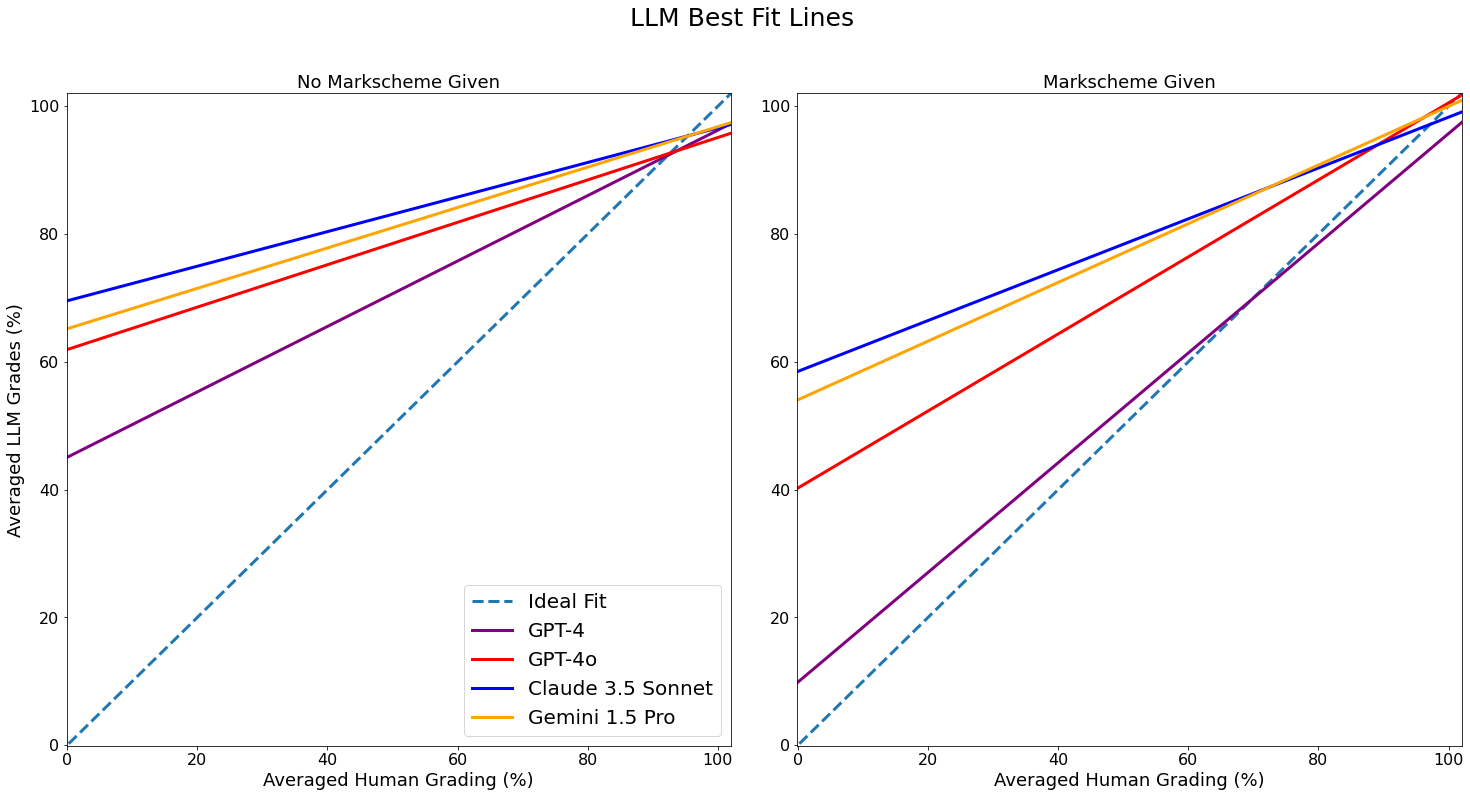

In [20]:
# Create a new figure with 2x2 subplots
fig = plt.figure(figsize=(25, 12))
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.0)

# Create and set the first subplot
ax1 = fig.add_subplot(1, 2, 1)
    
plt.title('No Markscheme Given', fontsize=18)
plt.plot(np.linspace(-5,110,100), np.linspace(-5,110,100), '--', linewidth=3, label='Ideal Fit')
    
#best fit plots of all LLMs (no markscheme)
plt.plot(np.linspace(-5,110,200),np.poly1d(p_gpt4_nms)(np.linspace(-5,110,200)), 
         linewidth=3, label='GPT-4', color='purple')
plt.plot(np.linspace(-5,110,200),np.poly1d(p_gpt4o_nms)(np.linspace(-5,110,200)), 
         linewidth=3, label='GPT-4o', color='red')
plt.plot(np.linspace(-5,110,200),np.poly1d(p_claude_nms)(np.linspace(-5,110,200)), 
         linewidth=3, label='Claude 3.5 Sonnet', color='blue')
plt.plot(np.linspace(-5,110,200),np.poly1d(p_gem_nms)(np.linspace(-5,110,200)), 
         linewidth=3, label='Gemini 1.5 Pro', color='orange')

plt.xlabel('Averaged Human Grading (%)', fontsize=18)
plt.ylabel('Averaged LLM Grades (%)', fontsize=18)

plt.xlim(-0.1,102)
plt.ylim(-0.1,102)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', fontsize=20)

ax2 = fig.add_subplot(1, 2, 2)

plt.title('Markscheme Given', fontsize=18)
plt.plot(np.linspace(-5,110,100), np.linspace(-5,110,100), '--', linewidth=3)

#best fit plots of all LLMs (with markscheme)
plt.plot(np.linspace(-5,110,200),np.poly1d(p_gpt4_ms)(np.linspace(-5,110,200)), 
         linewidth=3, label='GPT-4', color='purple')
plt.plot(np.linspace(-5,110,200),np.poly1d(p_gpt4o_ms)(np.linspace(-5,110,200)), 
         linewidth=3, label='GPT-4o', color='red')
plt.plot(np.linspace(-5,110,200),np.poly1d(p_claude_ms)(np.linspace(-5,110,200)), 
         linewidth=3, label='Claude 3.5 Sonnet', color='blue')
plt.plot(np.linspace(-5,110,200),np.poly1d(p_gem_ms)(np.linspace(-5,110,200)), 
         linewidth=3, label='Gemini 1.5 Pro', color='orange')

plt.xlabel('Averaged Human Grading (%)', fontsize=18)

plt.xlim(-0.1,102)
plt.ylim(-0.1,102)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.suptitle('LLM Best Fit Lines', fontsize=25);